In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import numpy as np
import pandas as pd
import sqlite3
import os 
import re
from typing import Tuple, Dict, List
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
# import definition
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

#### 1. import the Roberta Model

In [4]:
roberta = 'cardiffnlp/twitter-roberta-base-sentiment'

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(roberta)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing RobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for pred

In [6]:
tokenizer = AutoTokenizer.from_pretrained(roberta)

#### 2. Preprocessing text

In [3]:
from Tools.preprocessing import preprocessing_text

#### 3. Functions to extract sentiment scores 

In [8]:
def extract_sentiment_score(text: str) -> Tuple:
    """
    extract the sentiment score for a input text
    ----------
    param: text
    return: return tuple (labels, polarity)
        labels: can be ['Negative', 'Neutral', 'Positive']
        polarity: can be between 0 and 1
    """
    # preprocessing
    text = preprocessing_text(text)
    #extract score
    labels = ['Negative', 'Neutral', 'Positive']
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = softmax(output[0][0].detach().numpy())
    ranking = np.argsort(scores)[-1]
    l = labels[ranking]
    a = np.array([-1, 0, 1])
    polarity = sum([i*j for i, j in zip(scores, a)])
    return (l, polarity)

#### 4. Connect to the database

In [9]:
con = sqlite3.connect('../../database/database.db')

In [10]:
# get KLM tables
df = pd.read_sql_query('''
    SELECT id, text, user_id, lang
    FROM KLM_tweets
''', con)

In [11]:
# change datatype
df = df.astype({
    'id' : 'float64',
    'user_id' : 'float64'
})
df = df.astype({
    'user_id' : 'Int64'
})

In [10]:
# extract only tweets made by customers
df = df[df.user_id != 56377143]
df = df[df.lang == 'en']
df.shape

(65659, 4)

In [12]:
df_light = df[:1000]

In [13]:
df_light.head()

,id,text,user_id,lang
0,1.131174e+18,@Pelusitaaaa1 Hoi! Enkel KLM/Air France-vluch...,56377143,nl
1,1.131185e+18,@Pelusitaaaa1 We helpen je graag. Kan je ons e...,56377143,nl
2,1.131188e+18,@addblackman We understand that you would pref...,56377143,en
3,1.131188e+18,@CarlosMosig Con el fin de evitar errores noso...,56377143,es
4,1.131188e+18,@addblackman We do understand that some passen...,56377143,en


In [14]:
lst_label = []
lst_score = []
start = time.time()
count = 0
for text in df_light['text']:
    count += 1
    if count == 100 or count == 500 or count == 1000 or count == 2000:
        print(count)
    tup = extract_sentiment_score(text)
    lst_label.append(tup[0])
    lst_score.append(tup[1])
end = time.time()
end - start

100
500
1000


137.79255628585815

In [17]:
df_light.loc[:, 'label'] = lst_label
df_light.loc[:, 'sentiment_score'] = lst_score

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\PC\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [14]:
# Do the samething but for British Airways 
df_bri = pd.read_sql_query('''
    SELECT id, text, user_id, lang
    FROM british_airways_tweets
''', con)
df_bri = df_bri.astype({
    'id' : 'float64',
    'user_id' : 'float64'
})
df_bri = df_bri.astype({
    'user_id' : 'Int64'
})
df_bri = df_bri[df_bri.user_id != 18332190]
df_bri = df_bri[df_bri.lang == 'en']
df_light_bri = df_bri[:1000]
lst_label = []
lst_score = []
count = 0
for text in df_light_bri['text']:
    count += 1
    if count == 100 or count == 500 or count == 1000 or count == 2000:
        print(count)
    tup = extract_sentiment_score(text)
    lst_label.append(tup[0])
    lst_score.append(tup[1])
df_light_bri.loc[:, 'label'] = lst_label
df_light_bri.loc[:, 'sentiment_score'] = lst_score

100
500
1000


C:\Users\PC\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\PC\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


#### 5. Conversation analysis

In [15]:
conversation = pd.read_sql_query("""
    SELECT airline_name, conversation_opener, id_1, id_2, id_3, id_4, id_5, id_6, id_7
    FROM conversation
""", con)

In [16]:
# filter only KLM conversation 
conversation = conversation[conversation.airline_name == 'KLM']
conversation.head();

In [17]:
conversation = conversation.astype({
    'id_1' : 'float64',
    'id_2' : 'float64',
    'id_3' : 'float64',
    'id_4' : 'float64',
    'id_5' : 'float64',
    'id_6' : 'float64',
    'id_7' : 'float64'
})

conversation.dtypes;

In [18]:
def start_end_customers_filter(df : pd.DataFrame) -> pd.DataFrame:
    """
    filter each conversation with the start and end tweets by customers 
    ---------
    param: df : conversation dataframe with all the id of tweets in a conversation
    return: a df with 2 attributes 
        open_tweet_sentiment : score of tweet at the start of conversation by customers
        closed_tweet_sentiment : score of tweet at the end of conversation by customers 
    """
    lst_open = []
    lst_close = []
    for index, row in df.iterrows():
        # get id of the opening
        if row.conversation_opener == 'customer':
            open = row.id_1
            if pd.notna(row.id_7):
                close = row.id_7
            elif pd.notna(row.id_5):
                close = row.id_5
            else:
                close = row.id_3
        else:
            open = row.id_2
            if pd.notna(row.id_6):
                close = row.id_6
            else:
                close = row.id_4
        lst_open.append(open)
        lst_close.append(close)
    
    open_close_df = pd.DataFrame({
        'open' : lst_open,
        'close' : lst_close
    })
    return open_close_df
    
        


In [19]:
sen_score = df_light[['id', 'sentiment_score']].copy()

In [20]:
# filter open close df
open_close_df = start_end_customers_filter(conversation)
open_close_df.shape

(6917, 2)

In [21]:
# get sentiment score for open tweet
a = open_close_df.merge(right=sen_score, left_on='open', right_on='id', how='left')
a.dropna(subset=['sentiment_score'], inplace=True)


In [22]:
# get sentiment score for close tweet
a = a.merge(right=sen_score, left_on='close', right_on='id', how='left', suffixes=('_open', '_close'))
a.dropna(subset=['sentiment_score_close'], inplace=True)
a.shape

(84, 6)

In [23]:
a.drop(columns=['id_open', 'id_close'], inplace=True)
a['sentiment_change'] = a.sentiment_score_close - a.sentiment_score_open

In [24]:
a['positive_change'] = a.sentiment_change > 0

In [25]:
a.head()

,open,close,sentiment_score_open,sentiment_score_close,sentiment_change,positive_change
0,1.131282e+18,1.131286e+18,0.683755,0.871838,0.188083,True
1,1.131284e+18,1.131286e+18,0.925672,0.871838,-0.053834,False
2,1.131284e+18,1.131286e+18,0.925672,0.871838,-0.053834,False
3,1.131450e+18,1.131453e+18,0.710891,0.978812,0.267921,True
4,1.131492e+18,1.131495e+18,0.885223,0.662562,-0.222661,False


In [33]:
# Do the samething for British Airways 
def conversation_analysis(conversation : pd.DataFrame, airline_name : str, df_light) -> pd.DataFrame:
    conversation = conversation[conversation.airline_name == airline_name]
    conversation = conversation.astype({
        'id_1' : 'float64',
        'id_2' : 'float64',
        'id_3' : 'float64',
        'id_4' : 'float64',
        'id_5' : 'float64',
        'id_6' : 'float64',
        'id_7' : 'float64'
    })
    sen_score = df_light[['id', 'sentiment_score']].copy()
    open_close_df = start_end_customers_filter(conversation)
    # get sentiment score for open tweet
    bri = open_close_df.merge(right=sen_score, left_on='open', right_on='id', how='left')
    bri.dropna(subset=['sentiment_score'], inplace=True)
    # get sentiment score for close tweet
    bri = bri.merge(right=sen_score, left_on='close', right_on='id', how='left', suffixes=('_open', '_close'))
    bri.dropna(subset=['sentiment_score_close'], inplace=True)
    bri.drop(columns=['id_open', 'id_close'], inplace=True)
    bri['sentiment_change'] = bri.sentiment_score_close - bri.sentiment_score_open
    bri['positive_change'] = bri.sentiment_change > 0
    return bri
conversation = pd.read_sql_query("""
    SELECT airline_name, conversation_opener, id_1, id_2, id_3, id_4, id_5, id_6, id_7
    FROM conversation
""", con)

bri = conversation_analysis(conversation, 'British_Airways', df_light_bri)

#### 6. visualisation 

In [38]:
a['airline'] = ['KLM' for x in range(len(a))]

In [40]:
bri['airline'] = ['British Airways' for x in range(len(bri))]

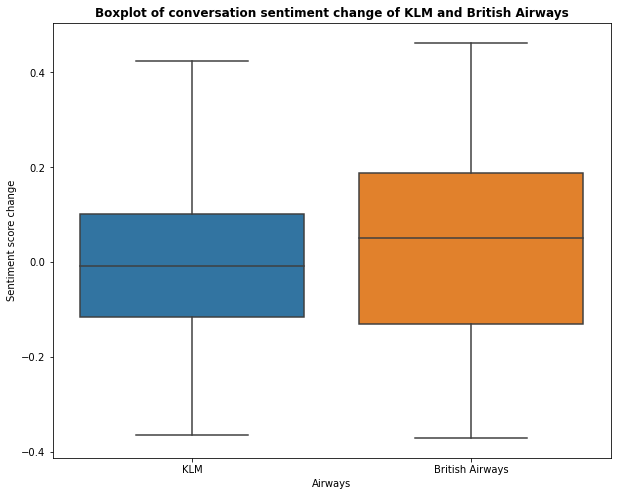

In [60]:
final = pd.concat([a, bri])
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x="airline", y="sentiment_change", data=final, ax=ax, orient="v")
ax.set_title('Boxplot of conversation sentiment change of KLM and British Airways', size=12, weight='bold')
ax.set_xlabel('Airways', size=10)
ax.set_ylabel('Sentiment score change', size=10);

In [72]:
sth = final.groupby(['airline', 'positive_change'], as_index=False).count()
# sns.barplot(data=sth, x='airline', y='sentiment_change', hue='positive_change')
sth[['airline', 'positive_change', 'open']]

,airline,positive_change,open
0,British Airways,False,31
1,British Airways,True,36
2,KLM,False,45
3,KLM,True,39


Text(0, 0.5, 'Proportions')

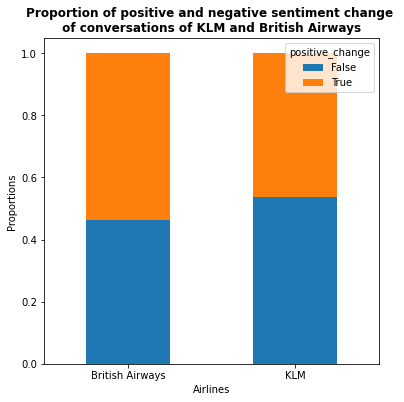

In [95]:
sth_else = final[['positive_change', 'airline']].copy()
sth_else.head()
cross_tab_prop = pd.crosstab(index=sth_else['airline'],
                             columns=sth_else['positive_change'],
                             normalize="index")

ax = cross_tab_prop.plot(kind='bar', 
                    stacked=True,  
                    figsize=(6, 6))
ax.set_xticklabels(['British Airways', 'KLM'], rotation='horizontal')
# ax.legend(['tweets mention KLM', 'tweets KLM reply'])
ax.set_title('Proportion of positive and negative sentiment change \n of conversations of KLM and British Airways ', size=12, weight='bold')
ax.set_xlabel('Airlines', size=10)
ax.set_ylabel('Proportions', size=10)

#### 7. New extra 2

In [69]:
df = pd.read_sql_query("""
    SELECT id, user_id, text, in_reply_to_user_id, lang
    FROM general_tweets
""", con)

In [70]:
df = df[df.lang == 'en']

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-70-6b745e987a0b>", line 1, in <module>
    df = df[df.lang == 'en']
  File "C:\Users\PC\anaconda3\lib\site-packages\pandas\core\frame.py", line 3015, in __getitem__
    return self._getitem_bool_array(key)
  File "C:\Users\PC\anaconda3\lib\site-packages\pandas\core\frame.py", line 3070, in _getitem_bool_array
    return self._take_with_is_copy(indexer, axis=0)
  File "C:\Users\PC\anaconda3\lib\site-packages\pandas\core\generic.py", line 3600, in _take_with_is_copy
    result = self.take(indices=indices, axis=axis)
  File "C:\Users\PC\anaconda3\lib\site-packages\pandas\core\generic.py", line 3586, in take
    new_data = self._mgr.take(
  File "C:\Users\PC\anaconda3\lib\site-packages\pandas\core\internals\managers.py", line 1474, in take
    return self.reindex_indexer(
  F

TypeError: object of type 'NoneType' has no len()

In [37]:
# import definition
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from definitions.airlines import airlines_id, airlines_name

In [ ]:
df_light = df[df['in_reply_to_user_id'].isna()][:10000][['text']]

In [ ]:
#Extract only tweets mention KLM (@KLM etc...):
def extract_tweet_mention_airlines(airline_name : str, df_data : pd.DataFrame) -> pd.DataFrame:
    """
    extract tweets that made by an airline
    :parameter airline_name: the string name of the airline
    :return DataFrame with one tweets mention that airline
    """

    ind2 = []
    for index, row in df_data.iterrows():
        if airline_name in row['text']:
            ind2.append(index)
    airline_tweet_men = df_data.loc[ind2]
    return airline_tweet_men

In [ ]:
lst = []
for airline in airlines_name.values():
    a = extract_tweet_mention_airlines(airline, df_light)
    a['airline'] = [airline for _ in range(len(a))]
    lst.append(a)

In [ ]:
sth = pd.concat(lst)

In [ ]:
lst_score = []
lst_label = []
for index, row in sth.iterrows():
    a = extract_sentiment_score(row.text)
    lst_score.append(a[1])
    lst_label.append(a[0])

In [ ]:
sth['label'] = lst_label
sth['score'] = lst_score

In [68]:
sth.head()

,text,airline,label,score
13,â˜€ PrÃ¡zdninovÃ© letenky na FaerskÃ© ostrovy ...,KLM,Neutral,-0.072609
20,Op dit moment vliegt #KLM vlucht KLM51K richti...,KLM,Neutral,-0.031769
74,I will inform KLM about this serious requireme...,KLM,Neutral,-0.125611
100,Waar @KLM de slots vandaan haalt is (nog) niet...,KLM,Neutral,-0.097811
150,KLM wil treingebruik op korte routes stimulere...,KLM,Neutral,-0.084838
